In [42]:
!pip install deepface

import cv2
import numpy as np
from deepface import DeepFace
from google.colab.patches import cv2_imshow
import os
from google.colab import files

In [79]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Uploaded image: {image_path}")

Saving ChatGPT Image Jul 14, 2025, 10_02_43 AM.png to ChatGPT Image Jul 14, 2025, 10_02_43 AM (1).png
Uploaded image: ChatGPT Image Jul 14, 2025, 10_02_43 AM (1).png


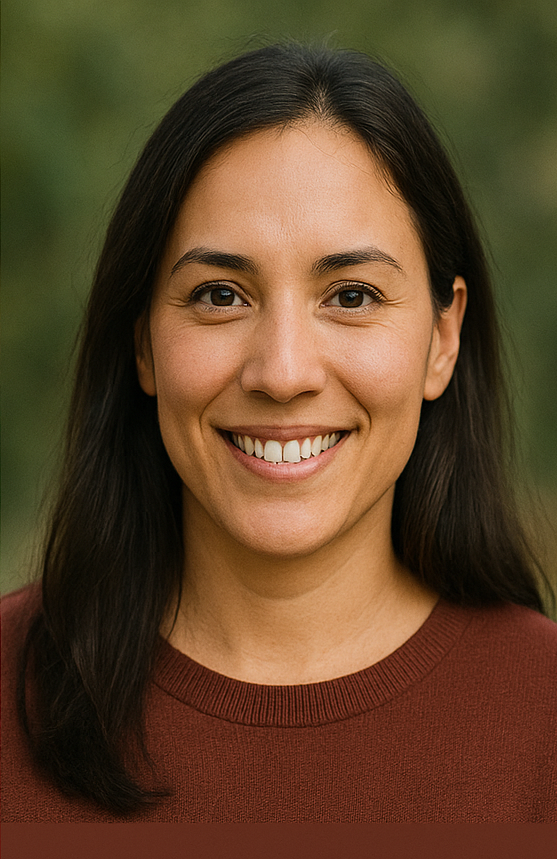

In [80]:
# Display the uploaded image
img = cv2.imread(image_path)
cv2_imshow(img)

In [81]:
result = DeepFace.analyze(img_path=image_path, actions=['age', 'gender', 'emotion', 'race'])

print("\nDeepFace Analysis Result:")
print(result)


Action: race: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


DeepFace Analysis Result:
[{'age': 25, 'region': {'x': 104, 'y': 147, 'w': 371, 'h': 371, 'left_eye': (348, 297), 'right_eye': (217, 298)}, 'face_confidence': np.float64(0.89), 'gender': {'Woman': np.float32(99.265335), 'Man': np.float32(0.73466086)}, 'dominant_gender': 'Woman', 'emotion': {'angry': np.float32(1.7745683e-13), 'disgust': np.float32(6.3847037e-24), 'fear': np.float32(3.4304043e-16), 'happy': np.float32(99.87174), 'sad': np.float32(1.0330581e-11), 'surprise': np.float32(5.0159684e-07), 'neutral': np.float32(0.12825467)}, 'dominant_emotion': 'happy', 'race': {'asian': np.float32(6.085424), 'indian': np.float32(2.153402), 'black': np.float32(0.53170377), 'white': np.float32(44.642433), 'middle eastern': np.float32(15.015209), 'latino hispanic': np.float32(31.571833)}, 'dominant_race': 'white'}]


In [82]:
# Display specific predictions
print("\nPredicted Age:", result[0]['age'])
print("Predicted Gender:", result[0]['gender'])
print("Dominant Emotion:", result[0]['dominant_emotion'])
print("Dominant Race:", result[0]['dominant_race'])


Predicted Age: 25
Predicted Gender: {'Woman': np.float32(99.265335), 'Man': np.float32(0.73466086)}
Dominant Emotion: happy
Dominant Race: white


In [83]:
if not os.path.exists("opencv_face_detector.pbtxt"):
    !wget https://github.com/spmallick/learnopencv/raw/master/AgeGender/opencv_face_detector.pbtxt
if not os.path.exists("opencv_face_detector_uint8.pb"):
    !wget https://github.com/spmallick/learnopencv/raw/master/AgeGender/opencv_face_detector_uint8.pb
if not os.path.exists("age_deploy.prototxt"):
    !wget https://github.com/spmallick/learnopencv/raw/master/AgeGender/age_deploy.prototxt
if not os.path.exists("age_net.caffemodel"):
    !wget https://github.com/GilLevi/AgeGenderDeepLearning/raw/master/models/age_net.caffemodel

In [84]:
face_proto = "opencv_face_detector.pbtxt"
face_model = "opencv_face_detector_uint8.pb"
age_proto = "age_deploy.prototxt"
age_model = "age_net.caffemodel"

In [85]:
face_net = cv2.dnn.readNetFromTensorflow(face_model, face_proto)
age_net = cv2.dnn.readNetFromCaffe(age_proto, age_model)

In [86]:
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']

In [87]:
def detect_faces(net, frame, conf_threshold=0.7):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    face_boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frame_width)
            y1 = int(detections[0, 0, i, 4] * frame_height)
            x2 = int(detections[0, 0, i, 5] * frame_width)
            y2 = int(detections[0, 0, i, 6] * frame_height)
            face_boxes.append([x1, y1, x2, y2])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), int(round(frame_height/150)), 8)
    return frame, face_boxes

In [88]:
def predict_age(face, net):
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    net.setInput(blob)
    age_preds = net.forward()
    age = age_list[age_preds[0].argmax()]
    return age

In [89]:
def process_image(image_path):
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Image not found at {image_path}")
        return
    frame, face_boxes = detect_faces(face_net, frame)
    for (x1, y1, x2, y2) in face_boxes:
        face = frame[max(0, y1-20):min(y2+20, frame.shape[0]-1),
                     max(0, x1-20):min(x2+20, frame.shape[1]-1)]
        age = predict_age(face, age_net)
        cv2.putText(frame, f"Age: {age}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    cv2_imshow(frame)



Running OpenCV Age Detection...


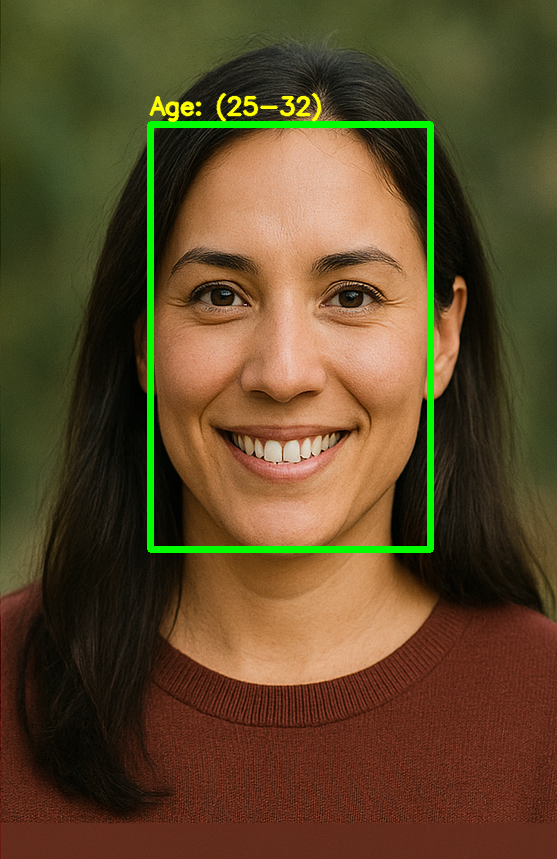

In [90]:
print("\nRunning OpenCV Age Detection...")
process_image(image_path)